In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Final_Model/stylegan2-swapper

/content/drive/MyDrive/Final_Model/stylegan2-swapper


In [ ]:
def resize_image(img):
  resized_img = None
  # Get the current resolution
  original_width, original_height = img.size
  if original_width != 1024 or original_height != 1024: # Check if resizing is needed
    target_resolution = (1024, 1024)
    resized_img = img.resize(target_resolution)
    resized_width, resized_height = resized_img.size
  else:
    resized_img = img
  # resized_img.save("resized_image.jpg")
  return resized_img

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.4 MB/s eta 0:00:00


In [ ]:
from mtcnn.mtcnn import MTCNN
import numpy as np

def detect_face(input_image):
  # Convert PIL Image to NumPy array
  input_array = np.asarray(input_image)
  face_recogniser = MTCNN()
  # Step 3: Face Detection
  faces = face_recogniser.detect_faces(input_array)
  return faces

In [ ]:
import imageio
import requests
import bz2
from PIL import Image
import torch
import torchvision.transforms as transforms
import dlib
from pix2pixHD.data.base_dataset import __scale_width
from pix2pixHD.models.networks import define_G
import pix2pixHD.util.util as util
from aligner import align_face

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import output
from IPython.display import HTML
import base64
import imageio
import io

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path

def download(url, file_name):
    with open(file_name, "wb") as file:
        response = requests.get(url)
        file.write(response.content)

In [ ]:
# Pre-trained model for facial landmark detection

import bz2
import shutil

# Define the paths
shape_model_drive_path = '/content/drive/MyDrive/Final_Model/shape_predictor_68_face_landmarks.dat.bz2'
shape_model_extracted_path = '/content/drive/MyDrive/Final_Model/shape_predictor_68_face_landmarks.dat'

# Extract the contents in Google Drive
with open(shape_model_extracted_path, 'wb') as new_file, bz2.BZ2File(shape_model_drive_path, 'rb') as file:
    shutil.copyfileobj(file, new_file)

# Load the model
shape_predictor = dlib.shape_predictor(shape_model_extracted_path)

In [ ]:
def get_eval_transform(loadSize=512):
    transform_list = []
    transform_list.append(transforms.Lambda(lambda img: __scale_width(img,
                                                                      loadSize,
                                                                      Image.BICUBIC)))
    transform_list += [transforms.ToTensor()]
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

transform = get_eval_transform()

In [ ]:
# To male:
!gdown --id 1-6J1CYLsIysk38X9DNN23lIcnvOr8aYh # https://drive.google.com/file/d/1-6J1CYLsIysk38X9DNN23lIcnvOr8aYh/view?usp=sharing

# To female:
!gdown --id 1frJERJr0WM_R38LnSFQ6XjGQtcXnLco1 # https://drive.google.com/file/d/1frJERJr0WM_R38LnSFQ6XjGQtcXnLco1/view?usp=sharing

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-6J1CYLsIysk38X9DNN23lIcnvOr8aYh 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1frJERJr0WM_R38LnSFQ6XjGQtcXnLco1
To: /content/drive/MyDrive/Final_Model/stylegan2-swapper/to_female_net_G.pth
100% 730M/730M [00:26<00:00, 27.3MB/s]


In [ ]:
config_G = {
    'input_nc': 3,
    'output_nc': 3,
    'ngf': 64,
    'netG': 'global',
    'n_downsample_global': 4,
    'n_blocks_global': 9,
    'n_local_enhancers': 1,
    'norm': 'instance',
}

In [ ]:
to_male_weights = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/to_male_net_G.pth'
to_male_model = define_G(**config_G)
pretrained_dict = torch.load(to_male_weights)
to_male_model.load_state_dict(pretrained_dict)
to_male_model.cuda();

to_female_weights = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/to_female_net_G.pth'
to_female_model = define_G(**config_G)
pretrained_dict = torch.load(to_female_weights)
to_female_model.load_state_dict(pretrained_dict)
to_female_model.cuda();

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

In [ ]:
# using torch
def find_cosine_similarity(input_tensor, generated_image):
  # Convert the NumPy array to a PyTorch tensor
  output_tensor = torch.from_numpy(generated_image).permute(2, 0, 1).unsqueeze(0).float()
  # Flatten the tensors to 1D vectors (if needed)
  tensor1_flat = input_tensor.view(1, -1)
  tensor2_flat = output_tensor.view(1, -1)

  # define a method to measure cosine similarity
  cos = torch.nn.CosineSimilarity(dim=1)
  output = cos(tensor1_flat, tensor2_flat)

  # display the output tensor
  return output

def get_similarity_percentage_using_torch(input_tensor, generated_image):
  cos = find_cosine_similarity(input_tensor, generated_image)
  percentage= ((cos.item() + 1) / 2) * 100
  return percentage


## **Cosine Similarity Input Image (Female)**


In [ ]:
img_url = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/CelebA_Attribute_Dataset/Female/000882.jpg'

aligned_img = align_face(img_url, shape_predictor)

if len(aligned_img) > 0:
  img = transform(aligned_img[0]).unsqueeze(0)
  with torch.no_grad():
    out = to_male_model(img.cuda())

  out = util.tensor2im(out.data[0])

  # Visualize the original image
  plt.subplot(1, 2, 1)
  plt.imshow(aligned_img[0])
  plt.title('Original Image')
  plt.axis('off')

  # Visualize the output image
  plt.subplot(1, 2, 2)
  plt.imshow(out)
  plt.title('Output Image')
  plt.axis('off')

  # Show the images
  plt.show()
  print("Cosine Similarity of Female Image: " + str(find_cosine_similarity(img, out)))
  print("Cosine Similarity % of Female Image: "+ str(get_similarity_percentage_using_torch(img, out)))

else:
  print("No face found")


000882.jpg: Number of faces detected: 0
No face found


## **Cosine Similarity Input Image (Male)**

000032.jpg: Number of faces detected: 1


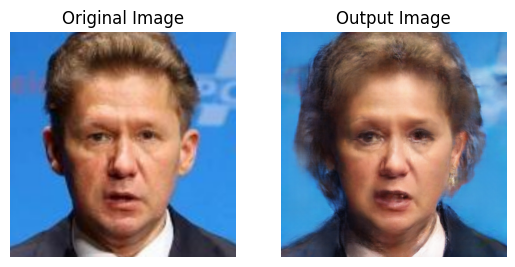

Cosine Similarity of Male Image: tensor([0.3279])
Cosine Similarity % of Male Image: 66.3966178894043


In [ ]:
img_url = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/CelebA_Attribute_Dataset/Male/000032.jpg'

aligned_img = align_face(img_url, shape_predictor)

if len(aligned_img) > 0:
  img = transform(aligned_img[0]).unsqueeze(0)
  with torch.no_grad():
    out = to_female_model(img.cuda())

  out = util.tensor2im(out.data[0])

  # Visualize the original image
  plt.subplot(1, 2, 1)
  plt.imshow(aligned_img[0])
  plt.title('Original Image')
  plt.axis('off')

  # Visualize the output image
  plt.subplot(1, 2, 2)
  plt.imshow(out)
  plt.title('Output Image')
  plt.axis('off')

  # Show the images
  plt.show()
  print("Cosine Similarity of Male Image: " + str(find_cosine_similarity(img, out)))
  print("Cosine Similarity % of Male Image: "+ str(get_similarity_percentage_using_torch(img, out)))
else:
  print("No face found")


**Testing for Average Similarity % between a dataset of female images**

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import time


to_male_model.eval()

# Path to your dataset folder in Google Drive
dataset_folder = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/CelebA_Attribute_Dataset/Female'

similarity_percentages_female = []

# Start the timer
start_time = time.time()
# Iterate through all files in the folder
for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Check if it's an image file
      # join path
      img_url = os.path.join(dataset_folder, filename)
      # align image
      aligned_img = align_face(img_url, shape_predictor)
      if len(aligned_img) > 0:
        img = transform(aligned_img[0]).unsqueeze(0)
        with torch.no_grad():
          out = to_male_model(img.cuda())
        out = util.tensor2im(out.data[0])
        percentage = get_similarity_percentage_using_torch(img, out)
        similarity_percentages_female.append(percentage)
      else:
        print("No face found: " + str(filename))
# Stop the timer
end_time = time.time()

# Calculate the time taken
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = int(elapsed_time % 60)

average = sum(similarity_percentages_female) / len(similarity_percentages_female)
print(f"Average Similarity Percentage: {average:.2f}%")
print(f"Time taken: {elapsed_minutes} minutes and {elapsed_seconds} seconds of {len(similarity_percentages_female)} files")



002142.jpg: Number of faces detected: 1
002140.jpg: Number of faces detected: 1
002137.jpg: Number of faces detected: 1
002134.jpg: Number of faces detected: 1
002136.jpg: Number of faces detected: 1
001720.jpg: Number of faces detected: 1
000884.jpg: Number of faces detected: 1
000883.jpg: Number of faces detected: 1
000882.jpg: Number of faces detected: 0
No face found000882.jpg
000887.jpg: Number of faces detected: 1
000890.jpg: Number of faces detected: 1
000893.jpg: Number of faces detected: 1
000891.jpg: Number of faces detected: 1
000897.jpg: Number of faces detected: 1
000894.jpg: Number of faces detected: 1
000896.jpg: Number of faces detected: 1
000895.jpg: Number of faces detected: 1
000899.jpg: Number of faces detected: 1
000900.jpg: Number of faces detected: 1
000901.jpg: Number of faces detected: 1
000909.jpg: Number of faces detected: 1
000910.jpg: Number of faces detected: 1
000912.jpg: Number of faces detected: 1
000916.jpg: Number of faces detected: 1
000914.jpg: Numb

**Testing for Average Similarity % between a dataset of male images**

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import time


to_female_model.eval()

# Path to your dataset folder in Google Drive
dataset_folder = '/content/drive/MyDrive/Final_Model/stylegan2-swapper/CelebA_Attribute_Dataset/Male'

similarity_percentages_male = []

# Start the timer
start_time = time.time()
# Iterate through all files in the folder
for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Check if it's an image file
      # join path
      img_url = os.path.join(dataset_folder, filename)
      # align image
      aligned_img = align_face(img_url, shape_predictor)
      if len(aligned_img) > 0:
        img = transform(aligned_img[0]).unsqueeze(0)
        with torch.no_grad():
          out = to_female_model(img.cuda())
        out = util.tensor2im(out.data[0])
        percentage = get_similarity_percentage_using_torch(img, out)
        similarity_percentages_male.append(percentage)
      # else:
      #   print("No face found: " + str(filename))
# Stop the timer
end_time = time.time()

# Calculate the time taken
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = int(elapsed_time % 60)

average = sum(similarity_percentages_male) / len(similarity_percentages_male)
print(f"Average Similarity Percentage: {average:.2f}%")
print(f"Time taken: {elapsed_minutes} minutes and {elapsed_seconds} seconds of {len(similarity_percentages_male)} files")



001193.jpg: Number of faces detected: 1
001196.jpg: Number of faces detected: 1
001197.jpg: Number of faces detected: 1
001199.jpg: Number of faces detected: 1
001201.jpg: Number of faces detected: 1
001204.jpg: Number of faces detected: 1
001207.jpg: Number of faces detected: 1
001208.jpg: Number of faces detected: 1
001206.jpg: Number of faces detected: 1
001210.jpg: Number of faces detected: 1
001209.jpg: Number of faces detected: 1
001213.jpg: Number of faces detected: 1
001216.jpg: Number of faces detected: 1
001215.jpg: Number of faces detected: 1
001217.jpg: Number of faces detected: 1
001222.jpg: Number of faces detected: 1
001220.jpg: Number of faces detected: 1
001224.jpg: Number of faces detected: 1
001225.jpg: Number of faces detected: 2
001229.jpg: Number of faces detected: 1
001228.jpg: Number of faces detected: 1
001231.jpg: Number of faces detected: 1
001230.jpg: Number of faces detected: 1
001239.jpg: Number of faces detected: 1
001237.jpg: Number of faces detected: 1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Pad the smaller list with NaNs to make them of equal length
max_length = max(len(similarity_percentages_male), len(similarity_percentages_female))
similarity_percentages_male += [np.nan] * (max_length - len(similarity_percentages_male))
similarity_percentages_female += [np.nan] * (max_length - len(similarity_percentages_female))


# Create a DataFrame for Seaborn
data = pd.DataFrame({'Male Dataset': similarity_percentages_male, 'Female Dataset': similarity_percentages_female})

# Plotting side by side boxplots
sns.boxplot(data=data, width=0.4)
plt.ylabel('Similarity Percentage')
plt.title('Box Plots of Similarity Percentage')
plt.show()

NameError: name 'similarity_percentages_male' is not defined

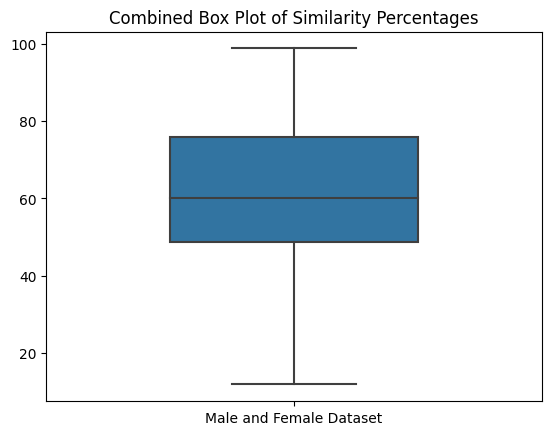

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a DataFrame for Seaborn
data = pd.DataFrame({'Male and Female Dataset': similarity_percentages_male + similarity_percentages_female})

sns.boxplot(data, width = 0.5)
# plt.xlabel('Similarity Percentage of Female Dataset')
plt.title('Combined Box Plot of Similarity Percentages')
plt.show()